In [1]:
import os
import math
import scipy.io
import numpy as np
import scipy.signal as sig
from scipy.io import wavfile
import matplotlib.pyplot as plt
from scipy.io.wavfile import read as wavread

In [2]:
"""
Function to read an audio file and return:
- Sample rate of the audio 
- data

ref: Audio Content Analysis by Alexander Lerch
"""
def ToolReadAudio(cAudioFilePath):
    [samplerate, x] = wavread(cAudioFilePath)

    if x.dtype == 'float32':
        audio = x
    else:
        # change range to [-1,1)
        if x.dtype == 'uint8':
            nbits = 8
        elif x.dtype == 'int16':
            nbits = 16
        elif x.dtype == 'int32':
            nbits = 32

        audio = x / float(2**(nbits - 1))

    # special case of unsigned format
    if x.dtype == 'uint8':
        audio = audio - 1.

    return (samplerate, audio)

In [3]:
"""
Function to calculate number of blocks and return:
    - a matrix xb (dimension NumOfBlocks X blockSize) 
    - a vector timeInSec (dimension NumOfBlocks)

ref: Audio Content Analysis by Alexander Lerch
"""

def  block_audio(x,blockSize,hopSize,fs):
    # allocate memory
    numBlocks = math.ceil(x.size / hopSize)
    print("numblocks=",numBlocks)
    xb = np.zeros([numBlocks, blockSize])
    # compute time stamps
    t = (np.arange(0, numBlocks) * hopSize) / fs

    x = np.concatenate((x, np.zeros(blockSize)),axis=0)

    for n in range(0, numBlocks):
        i_start = n * hopSize
        i_stop = np.min([x.size - 1, i_start + blockSize - 1])

        xb[n][np.arange(0,blockSize)] = x[np.arange(i_start, i_stop + 1)]

    return (xb,t)

In [34]:
"""
Function to calculate fft using hann window 
Returns the magnitude spectrum np array
"""
def compute_fft(block, hann, fs=44100):
    windowed_block = np.multiply(hann,block)
    block_fft = np.abs(np.fft.fft(windowed_block)[:int(block.size // 2)])
    return block_fft


"""
Function to calculate amplitude to dB values
"""
def convert_to_dB(value):
    return 20 * np.log10(np.abs(value))


"""
Function to calculate f0 from  using hann window 
Returns the magnitude spectrum np array
"""
def hps(block, factor, fft_size = None):
    #fft
    fft_size = fft_size or block.size
    hann = np.hanning(block.size) 
    
    # window and calculate fft
    block_fft = compute_fft(block, hann)
    half = int(np.ceil(block_fft.size))

    #downsample
    smallest_length = int(np.ceil(half/factor))
    d1 = block_fft[:smallest_length]
    d2 = block_fft[::2][:smallest_length]
    d3 = block_fft[::3][:smallest_length]
    d4 = block_fft[::4][:smallest_length]
    d5 = block_fft[::5][:smallest_length]
    
    print("sl:",smallest_length)
    #multiplication
    
   
    #normalize
    frequencies = np.arange(half)/half 
    frequencies = (frequencies[:smallest_length])*fs

#     plt.style.use(['dark_background','ggplot'])
    plt.plot(frequencies, convert_to_dB(d1))
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude (dB)')
    plt.title('Product Spectrums after no downsampling')
    plt.show()
    plt.plot(frequencies, convert_to_dB(d1*d2))
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude (dB)') 
    plt.title('Product Spectrums after 1 downsampling')
    plt.show()
    plt.plot(frequencies, convert_to_dB(d1*d2*d3))
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude (dB)')
    plt.title('Product Spectrums after 2 downsamplings')
    plt.show()
    plt.plot(frequencies, convert_to_dB(d1*d2*d3*d4))
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude (dB)')
    plt.title('Product Spectrums after 3 downsamplings')
    plt.show()
    plt.plot(frequencies, convert_to_dB(d1*d2*d3*d4*d5))
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude (dB)')
    plt.title('Product Spectrums after 4 downsamplings')
    plt.show()
    product = d1*d2*d3*d4*d5    
    
    maxpeak= np.argmax(product)
    f0 = frequencies[maxpeak]

    return product, frequencies, f0

numblocks= 99
(99, 1024)
sl: 103


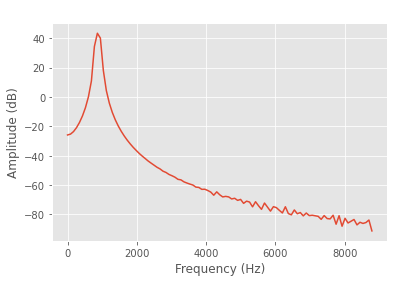

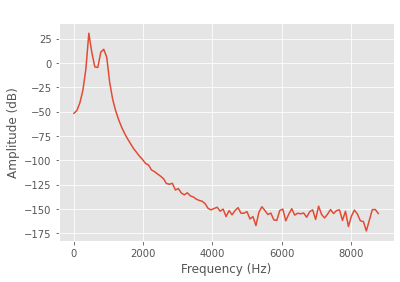

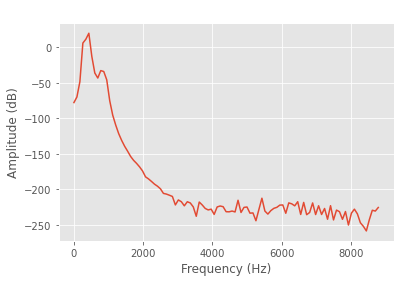

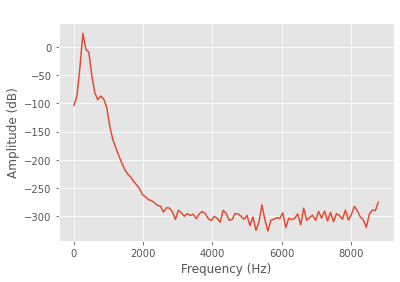

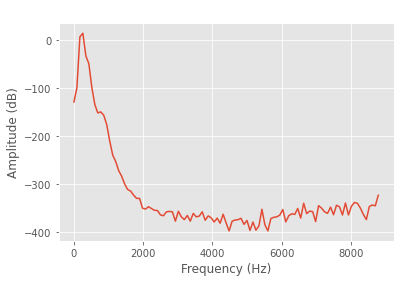

258.3984375


In [35]:
blockSize = 1024 
hopSize = 512
path = "./audio/sine440.wav"
fs, data = ToolReadAudio(path)
xb, timeInSec = block_audio(data,blockSize,hopSize,fs)
print(xb.shape)

[values, frequencies, f0] = hps(xb[33], 5)
print(f0)

numblocks= 173
sl: 205


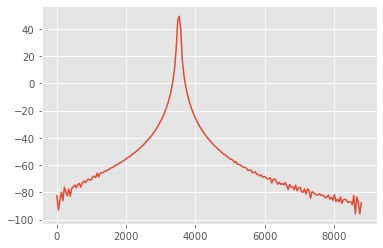

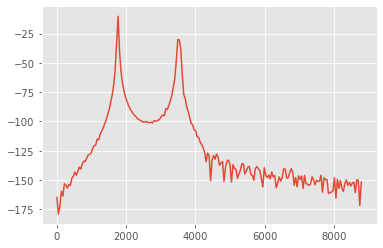

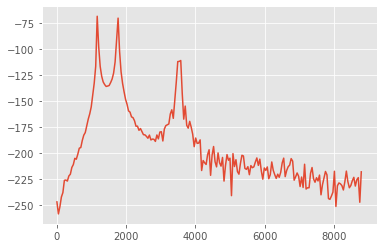

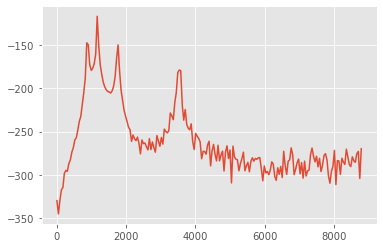

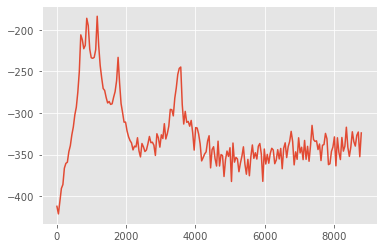

1162.79296875


In [21]:
blockSize = 2048 
hopSize = 512

fs, data = ToolReadAudio("./audio/sine1760.wav")
xb, timeInSec = block_audio(data,blockSize,hopSize,fs)

[values, frequencies, f0] = hps(xb[50], 5)
print(f0)

In [11]:
"""
name: get_pitch_from_txtfile
Function to extract pitch frequency column from the dataset. These values serve as ground truth in validating our results.
returns: frequency array (dimension NumOfBlocks in dataset)
"""
def get_pitch_from_txtfile(path):
    file = open(path, 'r')
    content = file.read()
    lines = content.split('\n')
    lines = list(filter(None, lines))
    freq = []
    for i in lines:
        freq.append(float(i.split()[2]))
    return np.array(freq)

<ipython-input-59-9299dcd3698b>:9: WavFileWarning: Chunk (non-data) not understood, skipping it.
  [samplerate, x] = wavread(cAudioFilePath)


numblocks= 8894


<ipython-input-61-4dadf509b103>:15: RuntimeWarning: divide by zero encountered in log10
  return 20 * np.log10(np.abs(value))


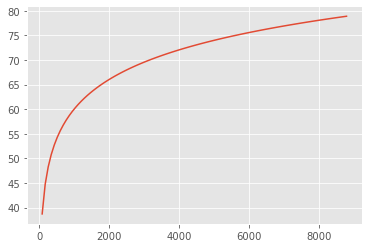

In [67]:
as1path = "./audio/trainData/01-D_AMairena.wav"
as1txtpath = "./audio/trainData/01-D_AMairena.f0.Corrected.txt"
blockSize = 1024 
hopSize = 128


fs, data = ToolReadAudio(as1path)
data = data.astype(float) / np.max(data) # normalize to -1 to 1
# data = data[:,0] + data[:,1] # stereo to mono
fs = float(fs)
freq_ground_truth = get_pitch_from_txtfile(as1txtpath)
xb, timeInSec = block_audio(data,blockSize,hopSize,fs)

[values, frequencies, f0] = hps(xb[25], 5)